In [1382]:
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.preprocessing import quantile_transform
from sklearn import preprocessing
from gudhi import RipsComplex
from gudhi import SimplexTree
from gudhi.weighted_rips_complex import WeightedRipsComplex
import gudhi.representations
import pandas as pd 
import numpy as np
import sklearn
import gudhi
import random
import math
import dcor 
import os

In [1383]:
#Read TCGA Data Renal, Breast and Colorectal Cancer

In [1522]:
def read_files_create_dataframe(path, ref):
    
    labelencoding = preprocessing.LabelEncoder()
    
    file_directory = '/Users/lebohangmashatola/Downloads/CRCPhenotypePredictionTool-main/expression/' + path
    df = pd.read_csv(file_directory, sep=',', index_col=0)
    df.columns = [ref] * df.shape[1]
    
    df = df.T
    df = df.drop(columns=np.nan)
    
    biomarker_genes = '/Users/lebohangmashatola/downloads/CRCPhenotypePredictionTool-main/biomarkers/morphogenesis.csv'
    #CSC.csv - moderate
    #DNA_replication.csv - high highest
    #dna_damage.csv - high
    #CRC.csv
    #cancer.csv
    #p53.csv - high betti-0 highest
    
    biomarkers = pd.read_csv(biomarker_genes, index_col=0, sep=';') 
    biomarkers = biomarkers["x"].to_numpy()   
    
    gene_exprs_matrix = df[np.intersect1d(df.columns, biomarkers)] #Subset biomarker genes
    
    return(gene_exprs_matrix)

In [1523]:
GSE19860_R = read_files_create_dataframe('GSE19860_RESISTANT_FOLFOX.csv', 'r')
GSE19860_S = read_files_create_dataframe('GSE19860_SENSITIVE_FOLFOX.csv', 's')

GSE28702_R = read_files_create_dataframe('GSE28702_RESISTANT_FOLFOX.csv', 'r')
GSE28702_S = read_files_create_dataframe('GSE28702_SENSITIVE_FOLFOX.csv', 's')

GSE52735_R = read_files_create_dataframe('GSE52735_RESISTANT_FOLFOX.csv', 'r')
GSE52735_S = read_files_create_dataframe('GSE52735_SENSITIVE_FOLFOX.csv', 's')

GSE69657_R = read_files_create_dataframe('GSE69657_RESISTANT_FOLFOX.csv', 'r')
GSE69657_S = read_files_create_dataframe('GSE69657_SENSITIVE_FOLFOX.csv', 's')

GSE72968_R = read_files_create_dataframe('GSE72968_RESISTANT_FOLFOX.csv', 'r')
GSE72968_S = read_files_create_dataframe('GSE72968_SENSITIVE_FOLFOX.csv', 's')

In [1524]:
array_r = pd.concat([GSE19860_R, GSE28702_R, GSE52735_R, GSE69657_R, GSE72968_R], axis=0)
array_r = quantile_transform(array_r, n_quantiles=5, random_state=0, copy=True)
array_r = np.array(array_r)

array_s = pd.concat([GSE19860_S, GSE28702_S, GSE52735_S, GSE69657_S, GSE72968_S], axis=0)
array_s = quantile_transform(array_s, n_quantiles=5, random_state=0, copy=True)
array_s = np.array(array_s)

In [1525]:
GSE81653_R = read_files_create_dataframe('GSE81653_FOLFOX_RESISTANT.csv', 'r')
GSE81653_S = read_files_create_dataframe('GSE81653_FOLFOX_SENSITIVE.csv', 's')

In [1526]:
GSE81653_R = np.array(GSE81653_R)
GSE81653_S = np.array(GSE81653_S)

In [1527]:
def read_files_rna_dataframe(path, ref):
    
    labelencoding = preprocessing.LabelEncoder()
    
    file_directory = '/Users/lebohangmashatola/Downloads/CRCPhenotypePredictionTool-main/expression/' + path
    df = pd.read_csv(file_directory, sep=',', index_col=0)
    
    biomarker_genes = '/Users/lebohangmashatola/downloads/CRCPhenotypePredictionTool-main/biomarkers/morphogenesis.csv'
    #CSC.csv
    #DNA_replication.csv
    #cholesterol_metabolism.csv
    #dna_damage.csv
    
    biomarkers = pd.read_csv(biomarker_genes, index_col=0, sep=';') 
    biomarkers = biomarkers["x"].to_numpy()   
    
    gene_exprs_matrix = df[np.intersect1d(df.columns, biomarkers)] #Subset biomarker genes
    
    return(np.array(gene_exprs_matrix))

In [1528]:
R = read_files_rna_dataframe('rnaseq_folfox_r.csv', 'r')
S = read_files_rna_dataframe('rnaseq_folfox_s.csv', 's')

In [1529]:
stage1 = read_files_rna_dataframe('stage1.csv', 'r')
stage4 = read_files_rna_dataframe('stage4.csv', 's')

In [1530]:
#Construct a distance correlations matrix for each disease and non-disease dataset

In [1531]:
def intergene_correlation_measure(DF):
    
    num_genes = DF.shape[1]
    dist = np.zeros((num_genes, num_genes))
    
    for i in range(num_genes):
        for j in range(i+1, num_genes):
            
            dist[i,j] = dcor.distance_correlation(DF[:,i], DF[:,j]) #Distance Correlations 
    
    dist = dist + dist.T + np.eye(num_genes)
    
    return 1 - dist

In [1532]:
M_R = intergene_correlation_measure(R.T)

In [1533]:
M_S = intergene_correlation_measure(S.T)

In [1534]:
M_stage1= intergene_correlation_measure(stage1.T)

In [1535]:
M_stage4= intergene_correlation_measure(stage4.T)

In [1536]:
M_GSE81653_R = intergene_correlation_measure(GSE81653_R.T)

In [1537]:
M_GSE81653_S = intergene_correlation_measure(GSE81653_S.T)

In [1538]:
M_array_r = intergene_correlation_measure(array_r.T)

In [1539]:
M_array_s = intergene_correlation_measure(array_s.T)

In [1540]:
#Construct persistent diagrams for each disease and non-disease distance correlations matrix

In [1541]:
def persistent_diagram(M_train, M_test):
    
    rips_complex_training = RipsComplex(M_train).create_simplex_tree(max_dimension=1)
    rips_complex_training.collapse_edges()
    rips_complex_training.expansion(2)
    rips_complex_training.persistence(persistence_dim_max=True)
    
    rips_complex_testing = RipsComplex(M_test).create_simplex_tree(max_dimension=1)
    rips_complex_testing.collapse_edges()
    rips_complex_testing.expansion(2)
    rips_complex_testing.persistence(persistence_dim_max=True)
    
    #gudhi.plot_persistence_diagram(rips_complex_training.persistence(persistence_dim_max=False), legend=True, fontsize=12)   
    #gudhi.plot_persistence_diagram(rips_complex_testing.persistence(persistence_dim_max=False), legend=True, fontsize=12)
    
    #Determine the wasserstein distance between two persistent diagram

    WD = gudhi.representations.metrics.WassersteinDistance(order=1)
    WD.fit([rips_complex_training.persistence_intervals_in_dimension(0)])
    wd_0 = WD.transform([rips_complex_testing.persistence_intervals_in_dimension(0)])
    
    WD = gudhi.representations.metrics.WassersteinDistance(order=1)
    WD.fit([rips_complex_training.persistence_intervals_in_dimension(1)])
    wd_1 = WD.transform([rips_complex_testing.persistence_intervals_in_dimension(1)])
    
    
    print("Wasserstein Distance (Betti-0): " + str(wd_0[0][0]))
    print("Wasserstein Distance (Betti-1): " + str(wd_1[0][0]))
    
    return np.array([wd_0, wd_1]).reshape(1,2)


In [1542]:
rna_WD = persistent_diagram(M_R, M_S) 
stage_WD = persistent_diagram(M_stage1, M_stage4) 
GSE_WD = persistent_diagram(M_GSE81653_R, M_GSE81653_S) 
array_WD = persistent_diagram(M_array_r, M_array_s) 

Wasserstein Distance (Betti-0): 1.3531544290319932
Wasserstein Distance (Betti-1): 0.04948534117965142
Wasserstein Distance (Betti-0): 7.962369353797728
Wasserstein Distance (Betti-1): 1.390540857653961
Wasserstein Distance (Betti-0): 38.42303051186502
Wasserstein Distance (Betti-1): 5.8723454701157785
Wasserstein Distance (Betti-0): 6.588980608064645
Wasserstein Distance (Betti-1): 3.2911519059085808


In [1410]:
import plotly.express as px
import matplotlib.pyplot as plt

def histogram(DF):
    
    df = pd.DataFrame(DF, columns=['Betti-0', 'Betti-1'], index=['Array', 'GSE81653', 'Stage4', 'RNA-Seq'])
    plt.figure(figsize=(2, 3), dpi = 250) 
    
    sns.set_theme(font_scale=0.5)
    sns.heatmap(df, annot=True, cmap="plasma", vmin=0, vmax=30, fmt='.1f')
    

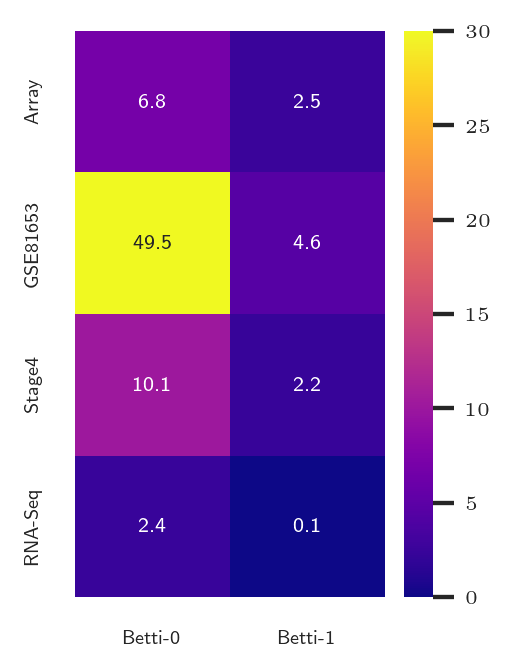

In [1433]:
PPAR = np.concatenate((array_WD,GSE_WD,stage_WD,rna_WD), axis=0)
histogram(PPAR)

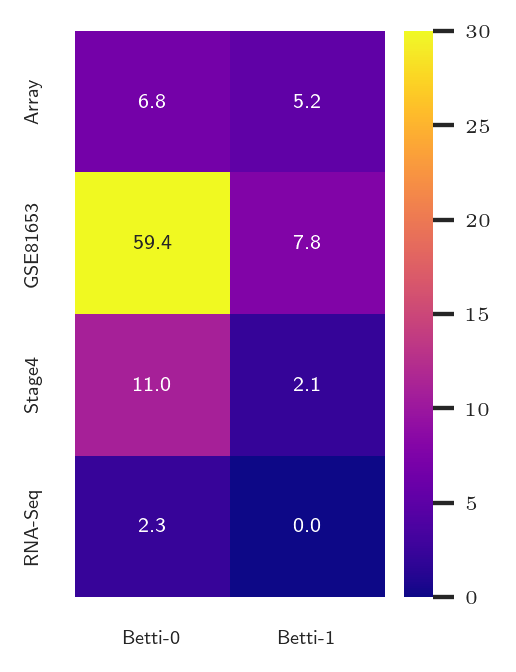

In [1411]:
glucosetrans = np.concatenate((array_WD2,GSE_WD2,stage_WD2,rna_WD2), axis=0)
histogram(glucosetrans)

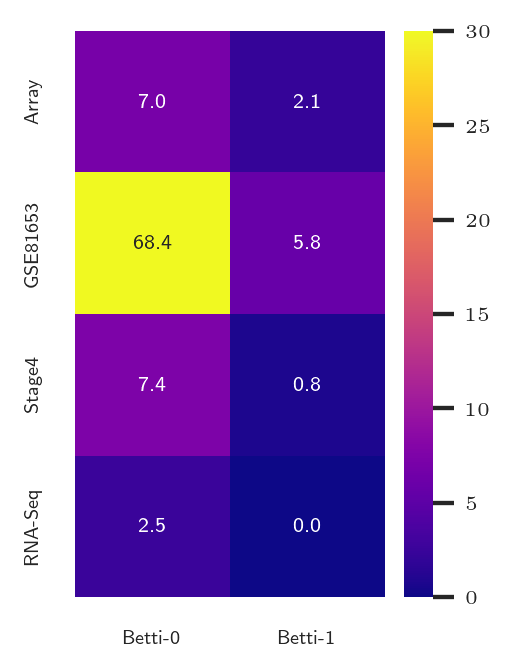

In [1455]:
choline = np.concatenate((array_WD,GSE_WD,stage_WD,rna_WD), axis=0)
histogram(choline)

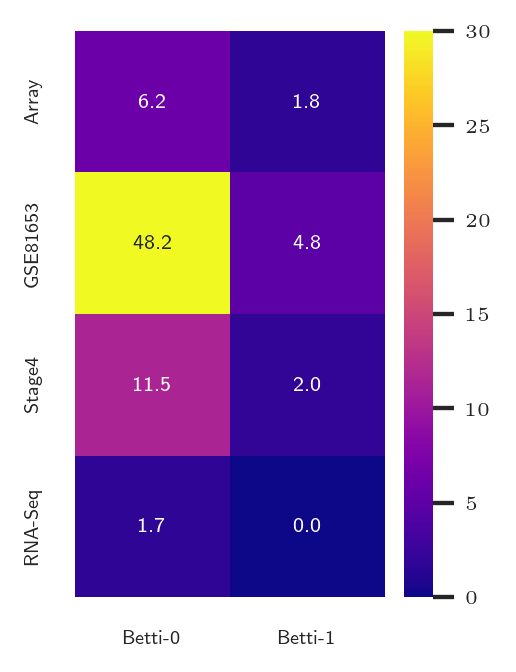

In [1477]:
cGMP = np.concatenate((array_WD,GSE_WD,stage_WD,rna_WD), axis=0)
histogram(cGMP)

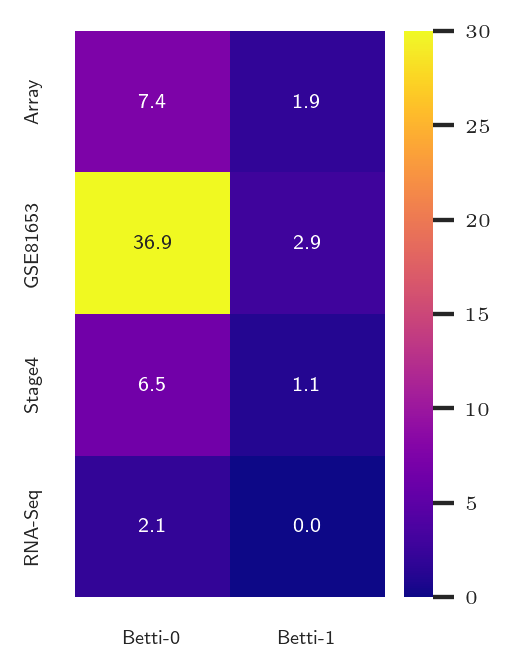

In [1499]:
apoptosis = np.concatenate((array_WD,GSE_WD,stage_WD,rna_WD), axis=0)
histogram(apoptosis)

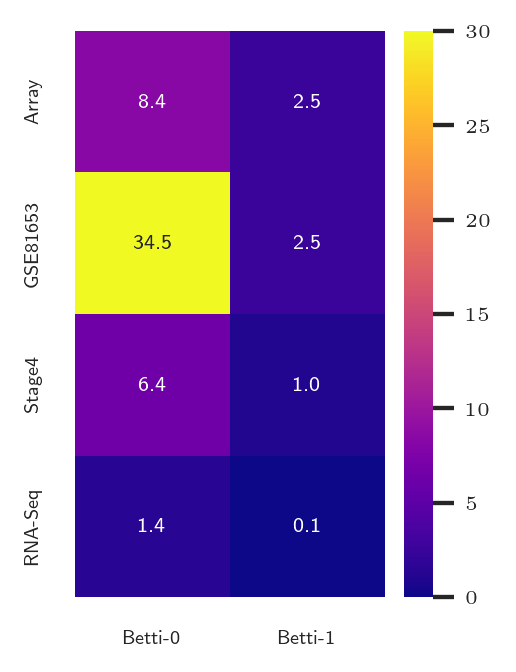

In [1521]:
hypoxia = np.concatenate((array_WD,GSE_WD,stage_WD,rna_WD), axis=0)
histogram(hypoxia)

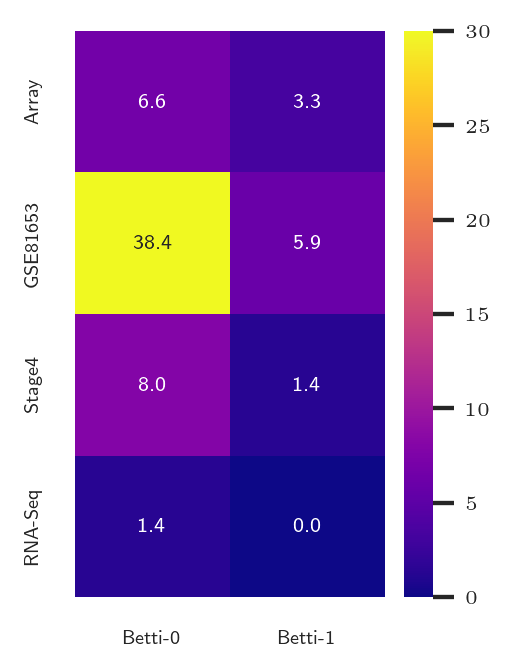

In [1543]:
morphogenesis = np.concatenate((array_WD,GSE_WD,stage_WD,rna_WD), axis=0)
histogram(morphogenesis)

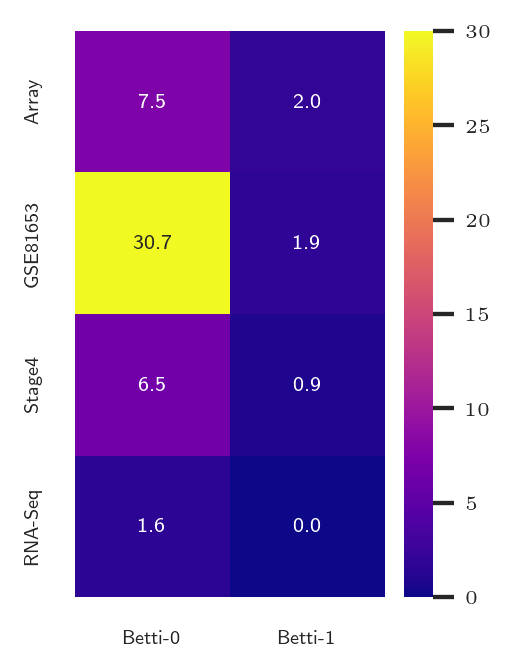

In [1544]:
Cancer = np.array([[7.522373377420949, 2.0418470010779437], 
                 [30.677045267493863, 1.8630938657999714], 
                 [6.546648296006877, 0.9052086259710833],
                 [1.5965843184528852, 0.014625179793395726]])

histogram(Cancer)

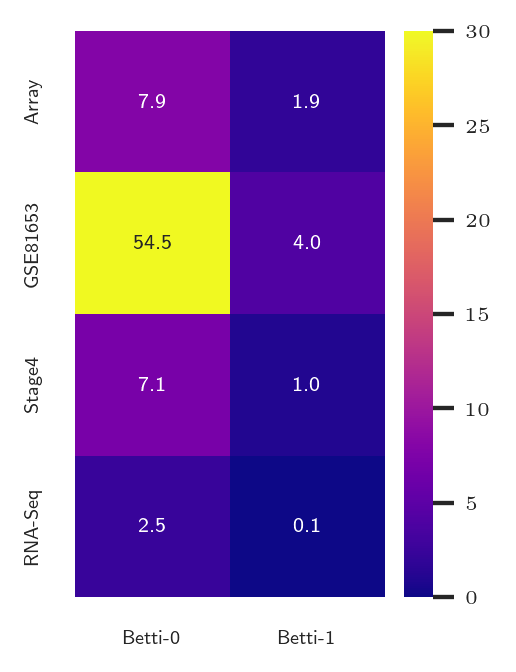

In [1545]:
CRC = np.array([[7.888312974961496, 1.9006703417194832], 
                 [54.45165413795174, 4.028587925790322], 
                 [7.116030869965211, 1.0014787731438848],
                 [2.4545203851070787, 0.08826308201271132]])

histogram(CRC)

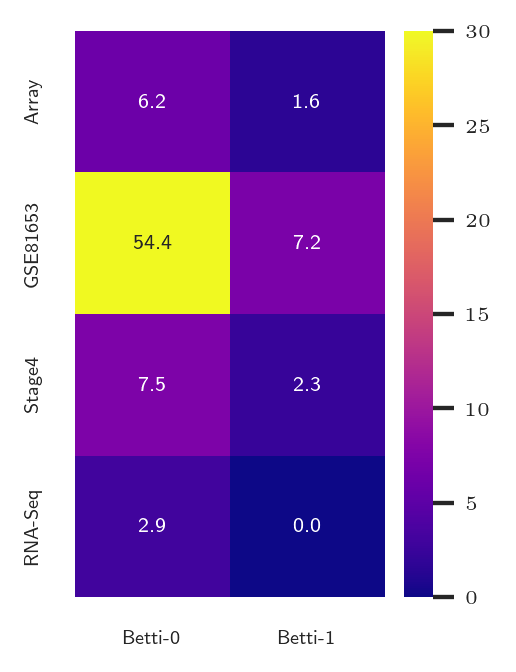

In [1546]:
DNA = np.array([[6.15880057034083, 1.5810665287138599], 
                 [54.43708711949544, 7.180129594490127], 
                 [7.4548424696121565, 2.3001091569929417],
                 [2.9461283292906533, 0.047877427757474944]])

histogram(DNA)

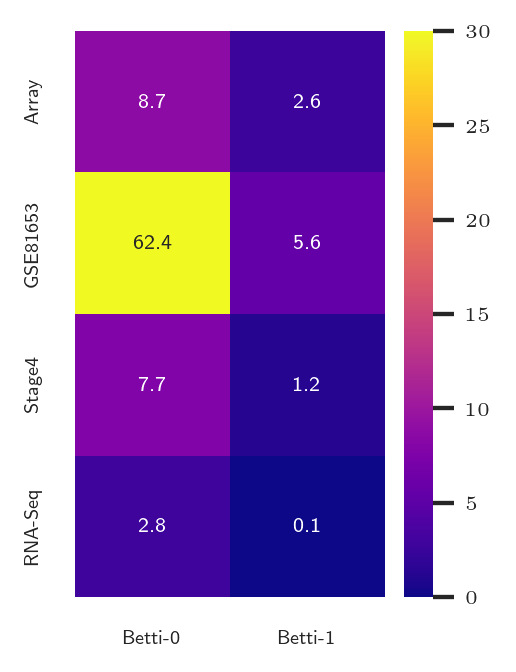

In [1547]:
p53 = np.array([[8.71754468696545, 2.6144630178402255], 
                 [62.392253683714685, 5.589922465660147], 
                 [7.703799490410868, 1.247552753281646],
                 [2.846026619105122, 0.11208037100223628]])

histogram(p53)

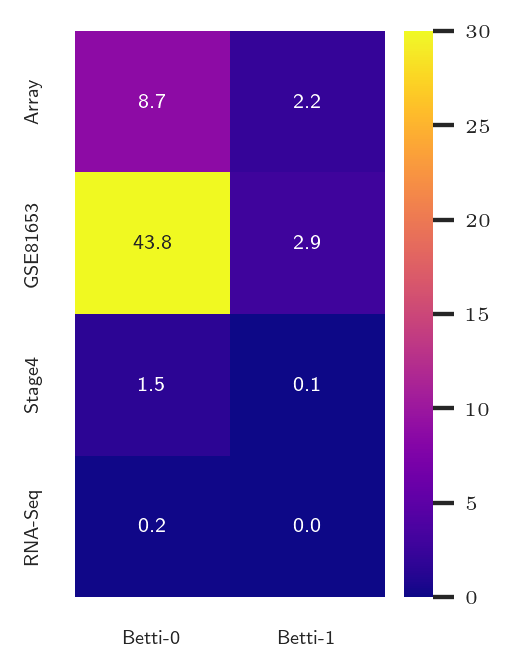

In [1548]:
CSC = np.array([[8.687149336554603, 2.1882699058376054], 
                 [43.79964133483758, 2.8790331938608458], 
                 [1.5366348964643228, 0.07195451692353748],
                 [0.22804173035476447, 0.0025404042899907914]])

histogram(CSC)

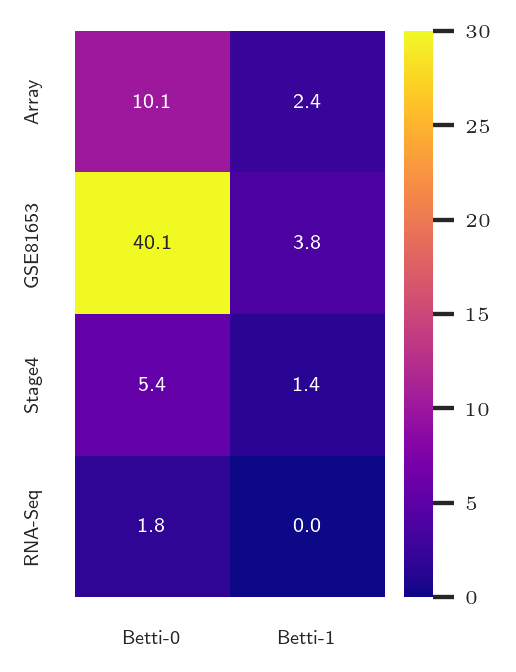

In [1549]:
Energy = np.array([[10.14292249875042, 2.3558322627720845], 
                 [40.113927389386, 3.7698185936772335], 
                 [5.413126705961571, 1.4185384653311313],
                 [1.7706191935326192, 0.024127303314747328]])

histogram(Energy)

In [1581]:
a = np.stack([Energy[:,0], CSC[:,0], p53[:,0], DNA[:,0], CRC[:,0], Cancer[:,0], morphogenesis[:,0], hypoxia[:,0], apoptosis[:,0], cGMP[:,0], choline[:,0], glucosetrans[:,0], PPAR[:,0]])

In [1583]:
a.shape

(13, 4)

In [1623]:
def histogram_all(DF):
    
    df = pd.DataFrame(DF, index=['Energy', 'CSC', 'p53', 'DNA', 'CRC', 'Cancer', 'Morph', 'Hypox', 'Apop', 'cGMP', 'Choli', 'Gluco', 'PPAR'], columns=['Array', 'GSE81653', 'Stage4', 'RNA-Seq'])
    plt.figure(figsize=(3, 4), dpi = 200) 
    
    sns.set_theme(font_scale=1.5)
    sns.clustermap(df, annot=True, cmap="plasma", fmt='.1f')

<Figure size 600x800 with 0 Axes>

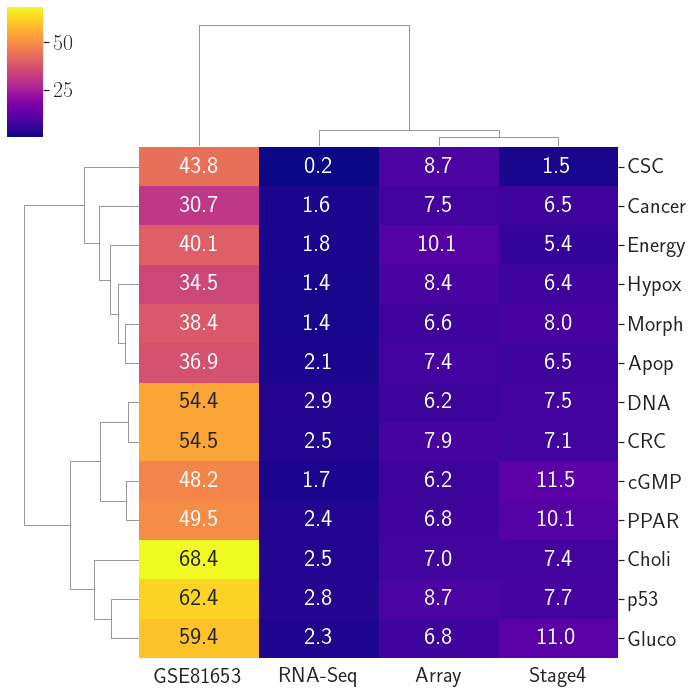

In [1624]:
histogram_all(a)